In [1]:
from collections import OrderedDict

import numpy as np
import nni
import torch

import nni.retiarii.nn.pytorch as nn
import pytorch_lightning as pl

from nni import trace
from nni.retiarii import model_wrapper
from nni.retiarii.nn.pytorch import Cell
from nni.retiarii.experiment.pytorch import RetiariiExperiment, RetiariiExeConfig
from nni.retiarii.strategy import DARTS as DartsStrategy
from nni.retiarii.evaluator.pytorch import Lightning, LightningModule, Trainer
from nni.retiarii.evaluator.pytorch.lightning import DataLoader
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.utilities.types import STEP_OUTPUT

from torch import optim, tensor, zeros_like
from typing import Any

from darts.common_utils import *
from darts.early_stop import MSE
from darts.noises import add_selected_noise
from darts.phantom import generate_phantom

from torch.utils.data import Dataset

/home/joe/.cache/pypoetry/virtualenvs/nas-test-OHy8kATa-py3.8/lib/python3.8/site-packages/lightning/fabric/__init__.py:29: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning.fabric')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)
/home/joe/.cache/pypoetry/virtualenvs/nas-test-OHy8kATa-py3.8/lib/python3.8/site-packages/pkg_resources/__init__.py:2350: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(parent)
/home/joe/.cache/pypoetry/virtualenvs/nas-test-OHy8kATa-py3.8/lib/

In [2]:
class SingleImageDataset(Dataset):
    def __init__(self, image, num_iter):
        self.image = image
        self.num_iter = num_iter

    def __len__(self):
        return self.num_iter

    def __getitem__(self, index):
        # Always return the same image (and maybe a noise tensor or other information if necessary??)
        return self.image

@trace
class LightningEvalSearch(LightningModule):
    def __init__(self, phantom=None, buffer_size=100, num_iter=50,
                lr=0.00005, noise_type='gaussian', noise_factor=0.15, resolution=6, 
                n_channels=1, reg_noise_std_val=1./30.):
        super().__init__()

        # input
        self.phantom = phantom

        # Loss
        self.criterion = nn.MSELoss().to(self.device)
        
        # Hyperparameters / Inputs
        self.buffer_size = buffer_size
        self.num_iter = num_iter
        self.lr = lr
        self.noise_type = noise_type
        self.noise_factor = noise_factor
        self.resolution = resolution
        self.n_channels = n_channels
        self.reg_noise_std = tensor(reg_noise_std_val)

        # adjusting input
        if self.phantom is None:
            self.img_np, _, _, self.img_noisy_torch = self.preprocess_image(self.resolution, self.noise_type, self.noise_factor)
        else:
            self.img_np, _, _, self.img_noisy_torch = self.preprocess_image(self.resolution, self.noise_type, self.noise_factor, input_img_np=self.phantom)
        self.net_input = get_noise(input_depth=1, spatial_size=self.img_np.shape[1], noise_type=self.noise_type)
        
        # History and early stopper
        self.loss_history = []
        self.variance_history = []
        self.img_collection = []
        
    def forward(self, net_input):
        net_input_perturbed = net_input + zeros_like(net_input).normal_(std=self.reg_noise_std)
        return self.model(net_input_perturbed)
    
    def training_step(self, batch, batch_idx):
        """
        Deep Image Prior

        training here follows closely from the following two repos: 
            - the deep image prior repo
            - a DIP early stopping repo (Lighting has early stopping functionality so this blends the two)
        """        

        r_img_torch = self.forward(self.net_input)
        r_img_np = torch_to_np(r_img_torch)

        # update loss and loss history
        total_loss = self.criterion(r_img_torch, self.img_noisy_torch)
        self.loss_history.append(total_loss.item())
        self.logger.log_metrics({'loss': total_loss.item()})

        # Using global_step to count iterations
        iterator = self.global_step

        # update img collection
        r_img_np = r_img_np.reshape(-1)
        self.update_img_collection(r_img_np)
        img_collection = self.get_img_collection()

        # if len(img_collection) == self.buffer_size:
        if len(img_collection) >= self.buffer_size // 2:

            # update variance and var history
            ave_img = np.mean(img_collection, axis=0)
            variance = [MSE(ave_img, tmp) for tmp in img_collection]
            self.cur_var = np.mean(variance)
            self.variance_history.append(self.cur_var)

            # update log
            self.latest_loss = total_loss.item()
            self.log('variance', self.cur_var)
            self.log('loss', self.latest_loss)
            nni.report_intermediate_result({'Iteration':iterator,'variance':self.cur_var, 'loss': self.latest_loss})

        return {"loss": total_loss}

    def configure_optimizers(self):
        """
        Basic Adam Optimizer
        """
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        return optimizer
    
    def optimizer_zero_grad(self, epoch, batch_idx, optimizer, opt_idx):
        # Not sure if this is the default logic in the nni.retiarii.evaluator.pytorch.LightningModule
        # needed to modify so it can accept the opt_idx argument
        optimizer.zero_grad()
    
    def configure_gradient_clipping(self, optimizer, opt_idx, gradient_clip_val, gradient_clip_algorithm):
        # Not sure if this is the default logic in the nni.retiarii.evaluator.pytorch.LightningModule
        # needed to modify so it can accept the opt_idx argument
        # now need to define the clipping logic
        self.clip_gradients(
            optimizer,
            gradient_clip_val=gradient_clip_val,
            gradient_clip_algorithm=gradient_clip_algorithm
        )


    def set_model(self, model):
        # This will be called after __init__ and will set the candidate model
        self.model = model
    
    def train_dataloader(self):
        """
        Dummy DataLoader that returns nothing but makes PyTorch Lightning's training loop work
        """
        dataset = SingleImageDataset(self.phantom, self.num_iter)
        return DataLoader(dataset, batch_size=1)
    
    def on_train_start(self):
        """
        Move all tensors to the GPU to begin training
        """
        self.model.to(self.device)
        self.net_input = self.net_input.to(self.device)
        self.img_noisy_torch = self.img_noisy_torch.to(self.device)
        self.reg_noise_std = self.reg_noise_std.to(self.device)

    def on_train_end(self, **kwargs: Any):
        """
        Report final PSNR to NNI and display the results
        """

        # final log
        # self.logger.log_metrics({'variance':self.cur_var, 'loss': self.latest_loss})
        # nni.report_final_result({'variance':self.cur_var, 'loss': self.latest_loss})

        # plot images to see results
        denoised_img = self.forward(self.net_input).detach().cpu().squeeze().numpy()
        
        fig, ax = plt.subplots(1, 3, figsize=(10, 5))

        ax[0].imshow(self.img_np.squeeze(), cmap='gray')
        ax[0].set_title("Original Image")
        ax[0].axis('off')

        ax[1].imshow(denoised_img, cmap='gray')
        ax[1].set_title("Denoised Image")
        ax[1].axis('off')

        ax[2].imshow(self.img_noisy_torch.detach().cpu().squeeze().numpy(), cmap='gray')
        ax[2].set_title("Noisy Image")
        ax[2].axis('off')

        plt.tight_layout()
        plt.show()

    # def test_step(self, *args: Any, **kwargs: Any) -> STEP_OUTPUT | None:
    #     pass

    def val_dataloader(self):
        """
        Dummy DataLoader for validation.
        """
        dataset = SingleImageDataset(self.phantom, self.num_iter)
        return DataLoader(dataset, batch_size=1)
    
    # def validation_step(self, trainer, *args: Any, **kwargs: Any) -> STEP_OUTPUT | None:
    #     # if self.buffer_size == len(self.img_collection):
    #     #     self._run_early_stopping_check(trainer)
    #     pass

    def update_img_collection(self, cur_img):
        self.img_collection.append(cur_img)
        if len(self.img_collection) > self.buffer_size:
            self.img_collection.pop(0)

    def get_img_collection(self):
        return self.img_collection

    def preprocess_image(self, resolution, noise_type, noise_factor, input_img_np=None):
        """
        Generates an image (or takes an input phantom), adds noise, and converts it to both numpy and torch tensors.

        Args:
        - resolution (int): Resolution for the phantom image.
        - noise_type (str): Type of noise to add.
        - noise_factor (float): Noise factor.
        - input_img_np (numpy.ndarray, optional): Input raw image in numpy format. If not provided, a new image will be generated.

        Returns:
        - img_np (numpy.ndarray): Original image in numpy format.
        - img_noisy_np (numpy.ndarray): Noisy image in numpy format.
        - img_torch (torch.Tensor): Original image in torch tensor format.
        - img_noisy_torch (torch.Tensor): Noisy image in torch tensor format.
        """
        if input_img_np is None:
            raw_img_np = generate_phantom(resolution=resolution) # 1x64x64 np array
        else:
            raw_img_np = input_img_np.copy() # 1x64x64 np array
            
        img_np = raw_img_np.copy() # 1x64x64 np array
        img_torch = torch.tensor(raw_img_np, dtype=torch.float32).unsqueeze(0) # 1x1x64x64 torch tensor
        img_noisy_torch = add_selected_noise(img_torch, noise_type=noise_type, noise_factor=noise_factor) # 1x1x64x64 torch tensor
        img_noisy_np = img_noisy_torch.squeeze(0).numpy() # 1x64x64 np array
        
        return img_np, img_noisy_np, img_torch, img_noisy_torch

class _EarlyStopping(EarlyStopping, pl.Callback):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

# attempt 1

In [45]:
def conv_2d(C_in, C_out, kernel_size=3, dilation=1, padding=1, affine=True):
    return nn.Sequential(
        nn.Conv2d(C_in, C_out, kernel_size=kernel_size, dilation=dilation, padding=padding, bias=False),
        nn.BatchNorm2d(C_out, affine=affine),
        nn.ReLU(),
        nn.Conv2d(C_out, C_out, kernel_size=kernel_size, dilation=dilation, padding=padding, bias=False),
        nn.BatchNorm2d(C_out, affine=affine),
        nn.ReLU()
    )

def depthwise_separable_conv(C_in, C_out, kernel_size=3, dilation=1, padding=1, affine=True):
    return nn.Sequential(
        nn.Conv2d(C_in, C_in, kernel_size=kernel_size, dilation=dilation, padding=padding, groups=C_in, bias=False),
        nn.Conv2d(C_in, C_out, 1, bias=False),
        nn.BatchNorm2d(C_out, affine=affine),
        nn.ReLU(),
        nn.Conv2d(C_out, C_out, kernel_size=kernel_size, dilation=dilation, padding=padding, groups=C_out, bias=False),
        nn.Conv2d(C_out, C_out, 1, bias=False),
        nn.BatchNorm2d(C_out, affine=affine),
        nn.ReLU()
    )

def maxpool_2d_conv2d(C_in, C_out):
    return nn.Sequential(
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        conv_2d(C_in, C_out)
        )

def maxpool_2d_depthwise_separable_conv(C_in, C_out):
    return nn.Sequential(
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        depthwise_separable_conv(C_in, C_out)
        )

def avgpool_2d_conv2d(C_in, C_out):
    return nn.Sequential(
        nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
        conv_2d(C_in, C_out)
        )

def avgpool_2d_depthwise_separable_conv(C_in, C_out):
    return nn.Sequential(
        nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
        depthwise_separable_conv(C_in, C_out)
        )

def nearest_upsample_conv2d(C_in, C_out, scale_factor=2):
    return nn.Sequential(
        nn.Upsample(scale_factor=scale_factor, mode='nearest'),
        conv_2d(C_in, C_out)
        )

def nearest_upsample_depthwise_separable_conv(C_in, C_out, scale_factor=2):
    return nn.Sequential(
        nn.Upsample(scale_factor=scale_factor, mode='nearest'),
        depthwise_separable_conv(C_in, C_out)
        )

def bilinear_upsample_conv2d(C_in, C_out, scale_factor=2):
    return nn.Sequential(
        nn.Upsample(scale_factor=scale_factor, mode='bilinear'),
        conv_2d(C_in, C_out)
        )

def bilinear_upsample_depthwise_separable_conv(C_in, C_out, scale_factor=2):
    return nn.Sequential(
        nn.Upsample(scale_factor=scale_factor, mode='bilinear'),
        depthwise_separable_conv(C_in, C_out)
        )

def encoder_ops(C_in,C_out):
    return OrderedDict([
    ("maxpool_2d_conv2d", maxpool_2d_conv2d(C_in, C_out)),
    ("maxpool_2d_depthwise_separable_conv", maxpool_2d_depthwise_separable_conv(C_in, C_out)),
    ("avgpool_2d_conv2d", avgpool_2d_conv2d(C_in, C_out)),
    ("avgpool_2d_depthwise_separable_conv", avgpool_2d_depthwise_separable_conv(C_in, C_out))
])

def decoder_ops(C_in,C_out):
    return OrderedDict([
    ("nearest_upsample_conv2d", nearest_upsample_conv2d(C_in, C_out)),
    ("nearest_upsample_depthwise_separable_conv", nearest_upsample_depthwise_separable_conv(C_in, C_out)),
    ("bilinear_upsample_conv2d", bilinear_upsample_conv2d(C_in, C_out)),
    ("bilinear_upsample_depthwise_separable_conv", bilinear_upsample_depthwise_separable_conv(C_in, C_out))
])

class DARTS_UNet(nn.Module):
    def __init__(self, C_in, C_out, num_cells=4):
        super(DARTS_UNet, self).__init__()

        # all padding should follow this formula:
        # pd = (ks - 1) * dl // 2
        
        self.in_layer = nn.Conv2d(C_in, 64, kernel_size=3, padding=1) 

        self.encoder_cells = nn.ModuleList([Cell(encoder_ops(64*(2**i), 64*(2**(i+1))), num_nodes=4, num_ops_per_node=1, num_predecessors=1) for i in range(num_cells)])
        self.decoder_cells = nn.ModuleList([Cell(decoder_ops(64*(2**(i))*3, 64*(2**i)), num_nodes=4, num_ops_per_node=1, num_predecessors=2) for i in range(num_cells)])  # num_predecessors=2 for skip connections
        # self.decoder_cells = self.decoder_cells[::-1]

        self.out_layer = nn.Conv2d(64, C_out, kernel_size=3, padding=1)

    def forward(self, x):
        print(f'input shape: {x.shape}')
        x = self.in_layer(x)  # Apply the initial layer
        print(f'input shape after in_layer: {x.shape}')

        skips = []
        for cell in self.encoder_cells:
            x = cell([x])
            skips.append(x)
            print(f'encoder shape: {x.shape}')

        for i, cell in enumerate(self.decoder_cells):
            x = cell([x, skips[-i-1]])  # Incorporate the skip connection
            print(f'decoder shape: {x.shape}')

        x = self.out_layer(x)  # Apply the final layer
        return x

    
    def test(self):
        """
        This will input a random tensor of 1x1x128x128 and test the forward pass.
        """
        x = torch.randn(1, 1, 128, 128)
        y = self.forward(x)
        assert y.shape == (1, 1, 128, 128), "Output shape should be (1, 1, 128, 128), got {}".format(y.shape)
        print("Test passed.")
        return y
    

model = DARTS_UNet(1, 1)
model.test()

input shape: torch.Size([1, 1, 128, 128])
input shape after in_layer: torch.Size([1, 64, 128, 128])
encoder shape: torch.Size([1, 512, 64, 64])


RuntimeError: Given groups=1, weight of size [256, 128, 3, 3], expected input[1, 512, 32, 32] to have 128 channels, but got 512 channels instead

# attempt 2

In [99]:
def conv_2d(C_in, C_out, kernel_size=3, dilation=1, padding=1):
    return nn.Sequential(
        nn.Conv2d(C_in, C_out, kernel_size=kernel_size, dilation=dilation, padding=padding, bias=False),
        nn.BatchNorm2d(C_out),
        nn.ReLU(),
        nn.Conv2d(C_out, C_out, kernel_size=kernel_size, dilation=dilation, padding=padding, bias=False),
        nn.BatchNorm2d(C_out),
        nn.ReLU()
    )

def depthwise_separable_conv(C_in, C_out, kernel_size=3, dilation=1, padding=1):
    return nn.Sequential(
        nn.Conv2d(C_in, C_in, kernel_size=kernel_size, dilation=dilation, padding=padding, groups=C_in, bias=False),
        nn.Conv2d(C_in, C_out, 1, bias=False),
        nn.BatchNorm2d(C_out),
        nn.ReLU(),
        nn.Conv2d(C_out, C_out, kernel_size=kernel_size, dilation=dilation, padding=padding, groups=C_out, bias=False),
        nn.Conv2d(C_out, C_out, 1, bias=False),
        nn.BatchNorm2d(C_out),
        nn.ReLU()
    )

def maxpool_2d_conv2d(C_in, C_out):
    return nn.Sequential(
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        conv_2d(C_in, C_out)
        )

def maxpool_2d_depthwise_separable_conv(C_in, C_out):
    return nn.Sequential(
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        depthwise_separable_conv(C_in, C_out)
        )

def avgpool_2d_conv2d(C_in, C_out):
    return nn.Sequential(
        nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
        conv_2d(C_in, C_out)
        )

def avgpool_2d_depthwise_separable_conv(C_in, C_out):
    return nn.Sequential(
        nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
        depthwise_separable_conv(C_in, C_out)
        )

def nearest_upsample_conv2d(C_in, C_out, scale_factor=2):
    return nn.Sequential(
        nn.Upsample(scale_factor=scale_factor, mode='nearest'),
        conv_2d(C_in, C_out)
        )

def nearest_upsample_depthwise_separable_conv(C_in, C_out, scale_factor=2):
    return nn.Sequential(
        nn.Upsample(scale_factor=scale_factor, mode='nearest'),
        depthwise_separable_conv(C_in, C_out)
        )

def bilinear_upsample_conv2d(C_in, C_out, scale_factor=2):
    return nn.Sequential(
        nn.Upsample(scale_factor=scale_factor, mode='bilinear'),
        conv_2d(C_in, C_out)
        )

def bilinear_upsample_depthwise_separable_conv(C_in, C_out, scale_factor=2):
    return nn.Sequential(
        nn.Upsample(scale_factor=scale_factor, mode='bilinear'),
        depthwise_separable_conv(C_in, C_out)
        )

def encoder_ops(C_in,C_out):
    return [
    maxpool_2d_conv2d(C_in, C_out),
    maxpool_2d_depthwise_separable_conv(C_in, C_out),
    avgpool_2d_conv2d(C_in, C_out),
    avgpool_2d_depthwise_separable_conv(C_in, C_out)
]

def decoder_ops(C_in,C_out):
    return [
    nearest_upsample_conv2d(C_in, C_out),
    nearest_upsample_depthwise_separable_conv(C_in, C_out),
    bilinear_upsample_conv2d(C_in, C_out),
    bilinear_upsample_depthwise_separable_conv(C_in, C_out)
]

def pools():
    return [
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
    ]

def upsamples():
    return [
        nn.Upsample(scale_factor=2, mode='nearest'),
        nn.Upsample(scale_factor=2, mode='bilinear'),
    ]

def convs(C_in, C_out):
    return [
        nn.Conv2d(C_in, C_out, kernel_size=3, padding=1),
        depthwise_separable_conv(C_in, C_out)
    ]

class Preprocessor:
    def __init__(self, C_in, C_out):
        self.conv1 = nn.Conv2d(C_in, C_out, kernel_size=3, dilation=1, padding=1)
        self.conv2 = nn.Conv2d(C_out, C_out, kernel_size=3, dilation=1, padding=1)

    def forward(self, x):
        return [self.conv1(x[0]), self.conv2(x[1])]

class Postprocessor:
    def __init__(self, C_in, C_out):
        self.conv1 = nn.Conv2d(64, C_out, kernel_size=3, dilation=1, padding=1)

    def forward(self, x):
        return  [self.conv1(x[0])]

class DARTS_UNet(nn.Module):
    def __init__(self, C_in, C_out, depth=4):
        super(DARTS_UNet, self).__init__()

        # all padding should follow this formula:
        # pd = (ks - 1) * dl // 2
        
        self.in_layer = nn.Conv2d(C_in, 64, kernel_size=3, padding=1)

        self.encoder_cells = nn.ModuleList([Cell(encoder_ops(64*(2**index), 64*(2**index)), num_nodes=2, num_ops_per_node=1, num_predecessors=1) for index in range(depth)])
        self.decoder_cells = nn.ModuleList([Cell(decoder_ops(int(64 * (2**(depth - index - 1)) * 2), int(64 * (2**(depth - index - 2)))), num_nodes=2, num_ops_per_node=1, num_predecessors=2) for index in range(depth)])

        self.out_layer = nn.Conv2d(64, C_out, kernel_size=3, padding=1)

    def forward(self, x):
        print(f'input shape: {x.shape}')
        x = self.in_layer(x)  # Apply the initial layer
        print(f'in_layer shape : {x.shape}')

        skip = []
        for cell in self.encoder_cells:
            x = cell(x)
            print(f'encoder shape: {x.shape}')
            skip.append(x)      
        
        for i, cell in enumerate(self.decoder_cells):
            upsampled = x  # this is our upsampled tensor
            cropped = self.crop_tensor(upsampled, skip[-(i+1)])  # cropping the skip connection tensor
            x = cell([upsampled, cropped])  # concatenate and pass both to the cell

            print(f'decoder shape: {x.shape}')
            
        x = self.out_layer(x)  # Apply the final layer
        return x

    def crop_tensor(self, target_tensor, tensor):
        target_size = target_tensor.size()[2]  # Assuming height and width are same
        tensor_size = tensor.size()[2]
        delta = tensor_size - target_size
        delta = delta // 2
        return tensor[:, :, delta:tensor_size-delta, delta:tensor_size-delta]
    
    def test(self):
        """
        This will input a random tensor of 1x1x128x128 and test the forward pass.
        """
        x = torch.randn(1, 1, 128, 128)
        y = self.forward(x)
        assert y.shape == (1, 1, 128, 128), "Output shape should be (1, 1, 128, 128), got {}".format(y.shape)
        print("Test passed.")
        return y
    

model = DARTS_UNet(1, 1)
model.test()

input shape: torch.Size([1, 1, 128, 128])
in_layer shape : torch.Size([1, 64, 128, 128])
encoder shape: torch.Size([1, 128, 64, 64])
encoder shape: torch.Size([1, 256, 32, 32])
encoder shape: torch.Size([1, 512, 16, 16])
encoder shape: torch.Size([1, 1024, 8, 8])
decoder shape: torch.Size([1, 512, 16, 16])
decoder shape: torch.Size([1, 256, 32, 32])
decoder shape: torch.Size([1, 128, 64, 64])
decoder shape: torch.Size([1, 64, 128, 128])
Test passed.


tensor([[[[ 0.2299,  0.1696,  0.3411,  ...,  0.1122,  0.1203,  0.2073],
          [ 0.3246,  0.1922,  0.1427,  ...,  0.2448, -0.0282,  0.0874],
          [ 0.5180,  0.2887,  0.2843,  ...,  0.2343,  0.1775,  0.1726],
          ...,
          [ 0.1878, -0.1503, -0.2356,  ...,  0.3955,  0.1373, -0.0754],
          [ 0.1055,  0.3037,  0.1431,  ...,  0.0749,  0.1474,  0.2108],
          [ 0.0536, -0.3216, -0.2727,  ..., -0.1282, -0.2698, -0.1735]]]],
       grad_fn=<MkldnnConvolutionBackward0>)

# test search in space 2

In [210]:
@model_wrapper
class DARTS_UNet(nn.Module):
    def __init__(self, C_in=1, C_out=1, depth=4):
        super().__init__()

        # all padding should follow this formula:
        # pd = (ks - 1) * dl // 2
        
        self.in_layer = nn.Conv2d(C_in, 64, kernel_size=3, padding=1)

        self.encoder_cells = nn.ModuleList([Cell(encoder_ops(64*(2**index), 64*(2**index)), num_nodes=2, num_ops_per_node=1, num_predecessors=1) for index in range(depth)])
        self.decoder_cells = nn.ModuleList([Cell(decoder_ops(int(64 * (2**(depth - index - 1)) * 2), int(64 * (2**(depth - index - 2)))), num_nodes=2, num_ops_per_node=1, num_predecessors=2) for index in range(depth)])

        self.out_layer = nn.Conv2d(64, C_out, kernel_size=3, padding=1)

    def forward(self, x):
        print(f'input shape: {x.shape}')
        x = self.in_layer(x)  # Apply the initial layer
        print(f'in_layer shape : {x.shape}')

        skip = []
        for cell in self.encoder_cells:
            x = cell([x])
            print(f'encoder shape: {x.shape}')
            skip.append(x)      
        
        for i, cell in enumerate(self.decoder_cells):
            upsampled = x  # this is our upsampled tensor
            cropped = self.crop_tensor(upsampled, skip[-(i+1)])  # cropping the skip connection tensor
            x = cell([upsampled, cropped])  # concatenate and pass both to the cell

            print(f'decoder shape: {x.shape}')
            
        x = self.out_layer(x)  # Apply the final layer
        return x

    def crop_tensor(self, target_tensor, tensor):
        target_size = target_tensor.size()[2]  # Assuming height and width are same
        tensor_size = tensor.size()[2]
        delta = tensor_size - target_size
        delta = delta // 2
        return tensor[:, :, delta:tensor_size-delta, delta:tensor_size-delta]
    
    def test(self):
        """
        This will input a random tensor of 1x1x128x128 and test the forward pass.
        """
        x = torch.randn(1, 1, 128, 128)
        y = self.forward(x)
        assert y.shape == (1, 1, 128, 128), "Output shape should be (1, 1, 128, 128), got {}".format(y.shape)
        print("Test passed.")
        return y

In [114]:

# input image (phantom)
resolution = 7
phantom = generate_phantom(resolution=resolution)

# early stopper
early_stop_callback = _EarlyStopping(
                        monitor="variance", 
                        mode="min", 
                        patience=6, 
                        verbose=True,
                        min_delta=0
                        )

# Create the lightning module
module = LightningEvalSearch(
                phantom=phantom, 
                buffer_size=100,
                num_iter=50,
                lr=0.00005, 
                noise_type='gaussian', 
                noise_factor=0.15, 
                resolution=resolution, 
                )

# Create a PyTorch Lightning trainer
trainer = Trainer(
            callbacks=[early_stop_callback],
            max_epochs=100, # (max_epochs)*(num_iter) = (Total Iterations) ---> 100 * 50 = 5000 iterations
            fast_dev_run=True,
            gpus=1,
            )
if not hasattr(trainer, 'optimizer_frequencies'):
    trainer.optimizer_frequencies = []


# Create the lighting object for evaluator
train_loader = DataLoader(SingleImageDataset(phantom, num_iter=50), batch_size=1)
val_loader = DataLoader(SingleImageDataset(phantom, num_iter=50), batch_size=1)

lightning = Lightning(lightning_module=module, trainer=trainer, train_dataloaders=train_loader, val_dataloaders=val_loader)


# Create a Search Space
model_space = DARTS_UNet(1,1,4)

# Select the Search Strategy
strategy = DartsStrategy()

fast_dev_run=False

config = RetiariiExeConfig(execution_engine='oneshot')
experiment = RetiariiExperiment(model_space, evaluator=lightning, strategy=strategy)
experiment.run(config)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).
`Trainer(limit_train_batches=1)` was configured so 1 batch per epoch will be used.
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_test_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_predict_batches=1)` was configured so 1 batch will be used.
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                | Params
----------------------------------------------
0 | model | LightningEvalSearch | 45.5 M
----------------------------------------------
45.5 M    Trainable params
0         Non-trainable params
45.5 M    Total params
181.855   Total estimated model params size (

Training: 0it [00:00, ?it/s]

input shape: torch.Size([1, 1, 128, 128])
in_layer shape : torch.Size([1, 64, 128, 128])


ValueError: Error when summing items. Value format / shape does not match. See full traceback for details.
  0: torch.Tensor(1, 64, 128, 128)
  1: torch.Tensor(1, 64, 64, 64)

# attempt 3

In [5]:
def conv_2d(C_in, C_out, kernel_size=3, dilation=1, padding=1):
    return nn.Sequential(
        nn.Conv2d(C_in, C_out, kernel_size=kernel_size, dilation=dilation, padding=padding, bias=False),
        nn.BatchNorm2d(C_out),
        nn.ReLU(),
        nn.Conv2d(C_out, C_out, kernel_size=kernel_size, dilation=dilation, padding=padding, bias=False),
        nn.BatchNorm2d(C_out),
        nn.ReLU()
    )

def depthwise_separable_conv(C_in, C_out, kernel_size=3, dilation=1, padding=1):
    return nn.Sequential(
        nn.Conv2d(C_in, C_in, kernel_size=kernel_size, dilation=dilation, padding=padding, groups=C_in, bias=False),
        nn.Conv2d(C_in, C_out, 1, bias=False),
        nn.BatchNorm2d(C_out),
        nn.ReLU(),
        nn.Conv2d(C_out, C_out, kernel_size=kernel_size, dilation=dilation, padding=padding, groups=C_out, bias=False),
        nn.Conv2d(C_out, C_out, 1, bias=False),
        nn.BatchNorm2d(C_out),
        nn.ReLU()
    )

def maxpool_2d_conv2d(C_in, C_out):
    return nn.Sequential(
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        conv_2d(C_in, C_out)
        )

def maxpool_2d_depthwise_separable_conv(C_in, C_out):
    return nn.Sequential(
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        depthwise_separable_conv(C_in, C_out)
        )

def avgpool_2d_conv2d(C_in, C_out):
    return nn.Sequential(
        nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
        conv_2d(C_in, C_out)
        )

def avgpool_2d_depthwise_separable_conv(C_in, C_out):
    return nn.Sequential(
        nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
        depthwise_separable_conv(C_in, C_out)
        )

def nearest_upsample_conv2d(C_in, C_out, scale_factor=2):
    return nn.Sequential(
        nn.Upsample(scale_factor=scale_factor, mode='nearest'),
        conv_2d(C_in, C_out)
        )

def nearest_upsample_depthwise_separable_conv(C_in, C_out, scale_factor=2):
    return nn.Sequential(
        nn.Upsample(scale_factor=scale_factor, mode='nearest'),
        depthwise_separable_conv(C_in, C_out)
        )

def bilinear_upsample_conv2d(C_in, C_out, scale_factor=2):
    return nn.Sequential(
        nn.Upsample(scale_factor=scale_factor, mode='bilinear'),
        conv_2d(C_in, C_out)
        )

def bilinear_upsample_depthwise_separable_conv(C_in, C_out, scale_factor=2):
    return nn.Sequential(
        nn.Upsample(scale_factor=scale_factor, mode='bilinear'),
        depthwise_separable_conv(C_in, C_out)
        )

def encoder_ops(C_in,C_out):
    return [
    maxpool_2d_conv2d(C_in, C_out),
    maxpool_2d_depthwise_separable_conv(C_in, C_out),
    avgpool_2d_conv2d(C_in, C_out),
    avgpool_2d_depthwise_separable_conv(C_in, C_out)
]

def decoder_ops(C_in,C_out):
    return [
    nearest_upsample_conv2d(C_in, C_out),
    nearest_upsample_depthwise_separable_conv(C_in, C_out),
    bilinear_upsample_conv2d(C_in, C_out),
    bilinear_upsample_depthwise_separable_conv(C_in, C_out)
]

def pools():
    return [
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
    ]

def upsamples():
    return [
        nn.Upsample(scale_factor=2, mode='nearest'),
        nn.Upsample(scale_factor=2, mode='bilinear'),
    ]

def convs(C_in, C_out):
    return [
        nn.Conv2d(C_in, C_out, kernel_size=3, padding=1),
        depthwise_separable_conv(C_in, C_out)
    ]

class Preprocessor:
    def __init__(self, C_in, C_out):
        self.conv1 = nn.Conv2d(C_in, C_out, kernel_size=3, dilation=1, padding=1)
        self.conv2 = nn.Conv2d(C_out, C_out, kernel_size=3, dilation=1, padding=1)

    def forward(self, x):
        return [self.conv1(x[0]), self.conv2(x[1])]

class Postprocessor:
    def __init__(self, C_in, C_out):
        self.conv1 = nn.Conv2d(64, C_out, kernel_size=3, dilation=1, padding=1)

    def forward(self, x):
        return  [self.conv1(x[0])]

In [164]:
class Preprocessor(nn.Module):
    def __init__(self, C_in, C_out):
        self.conv1 = nn.Conv2d(C_in, C_out, kernel_size=3, dilation=1, padding=1)

    def forward(self, x):
        return [self.conv1(x[0])]

@model_wrapper
class DARTS_UNet(nn.Module):
    def __init__(self, C_in=1, C_out=1, depth=4):
        super().__init__()

        # all padding should follow this formula:
        # pd = (ks - 1) * dl // 2
        
        self.in_layer = nn.Conv2d(C_in, 64, kernel_size=3, padding=1)

        self.pool = Cell(pools(), num_nodes=2, num_ops_per_node=1, num_predecessors=1)
        self.conv1 = Cell(convs(128, 64), num_nodes=2, num_ops_per_node=1, num_predecessors=1)

        self.encoders = nn.ModuleList([self.pool, self.conv1])

        self.up = Cell(upsamples(), num_nodes=2, num_ops_per_node=1, num_predecessors=1)
        self.conv2 = Cell(convs(256, 32), num_nodes=2, num_ops_per_node=1, num_predecessors=2) # still need skip connection so num_predecessors=2

        self.decoders = nn.ModuleList([self.up, self.conv2])

        self.out_layer = nn.Conv2d(64, C_out, kernel_size=3, padding=1)

    def forward(self, x, pr=False):

        if pr:
            print(f'input shape: {x.shape}\n')
        x = self.in_layer(x)  # Apply the initial layer
        if pr:
            print(f'in_la shape: {x.shape}\n')

        x = self.pool([x])
        if pr:
            print(f'pool  shape: {x.shape}')

        x = self.conv1([x])
        if pr:
            print(f'conv1 shape: {x.shape}\n')

        upsampled = self.up([x])
        if pr:
            print(f'upsam shape: {upsampled.shape}')

        cropped = self.crop_tensor(upsampled, x)  # cropping the skip connection tensor
        # x = cell([upsampled, cropped])  # concatenate and pass both to the cell
        x = self.conv2([upsampled, cropped])
        if pr:
            print(f'conv2 shape: {x.shape}\n')
            
        x = self.out_layer(x)  # Apply the final layer
        return x

    def crop_tensor(self, target_tensor, tensor):
        target_size = target_tensor.size()[2]  # Assuming height and width are same
        tensor_size = tensor.size()[2]
        delta = tensor_size - target_size
        delta = delta // 2
        return tensor[:, :, delta:tensor_size-delta, delta:tensor_size-delta]
    
    def test(self):
        """
        This will input a random tensor of 1x1x128x128 and test the forward pass.
        """
        x = torch.randn(1, 1, 128, 128)
        y = self.forward(x, pr=True)
        assert y.shape == (1, 1, 128, 128), "Output shape should be (1, 1, 128, 128), got {}".format(y.shape)
        print(f'output shape: {y.shape}\n')
        print("Test passed.\n\n")

model = DARTS_UNet(1, 1)
model.test()


input shape: torch.Size([1, 1, 128, 128])

in_la shape: torch.Size([1, 64, 128, 128])

pool  shape: torch.Size([1, 128, 64, 64])
conv1 shape: torch.Size([1, 128, 64, 64])

upsam shape: torch.Size([1, 256, 128, 128])
conv2 shape: torch.Size([1, 64, 128, 128])

output shape: torch.Size([1, 1, 128, 128])

Test passed.




/home/joe/.cache/pypoetry/virtualenvs/nas-test-OHy8kATa-py3.8/lib/python3.8/site-packages/nni/nas/nn/pytorch/choice.py:274: UserWarning: You should not run forward of this module directly.
  warnings.warn('You should not run forward of this module directly.')
/home/joe/.cache/pypoetry/virtualenvs/nas-test-OHy8kATa-py3.8/lib/python3.8/site-packages/nni/nas/nn/pytorch/choice.py:186: UserWarning: You should not run forward of this module directly.
  warnings.warn('You should not run forward of this module directly.')


In [233]:
class Preprocessor(nn.Module):
    def __init__(self, C_in, C_out):
        super().__init__()

        self.conv1 = nn.Conv2d(C_in, C_out, 1)

    def forward(self, x):
        return [self.conv1(x[0])]

class Postprocessor(nn.Module):
    def __init__(self, C_in, C_out):
        super().__init__()

        self.conv1 = nn.Conv2d(C_in, C_out, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(C_in, C_out, kernel_size=3, padding=1)

    def forward(self, x):
        return [self.conv1(x[0]), self.conv2(x[1])]

@model_wrapper
class DARTS_UNet(nn.Module):
    def __init__(self, C_in=1, C_out=1, depth=4):
        super().__init__()

        # all padding should follow this formula:
        # pd = (ks - 1) * dl // 2
        self.pr = False
        
        self.in_layer = nn.Conv2d(C_in, 64, kernel_size=3, padding=1)

        self.pool = Cell(pools(), num_nodes=1, num_ops_per_node=2, num_predecessors=1)
        self.conv1 = Cell(convs(64, 128), num_nodes=1, num_ops_per_node=2, num_predecessors=1)

        self.encoders = nn.ModuleList([self.pool, self.conv1])

        self.up = Cell(upsamples(), num_nodes=1, num_ops_per_node=2, num_predecessors=1)
        self.conv2 = Cell(convs(64*3, 64), num_nodes=1, num_ops_per_node=2, num_predecessors=1) # still need skip connection so num_predecessors=2

        self.decoders = nn.ModuleList([self.up, self.conv2])

        self.out_layer = nn.Conv2d(64, C_out, kernel_size=3, padding=1)

    def forward(self, x):

        if self.pr:
            print(f'input shape: {x.shape}\n')

        x = self.in_layer(x)  # Apply the initial layer
        if self.pr:
            print(f'in_la (x) shape: {x.shape}\n')

        x1 = self.pool([x])
        if self.pr:
            print(f'pool  (x1) shape: {x1.shape}')

        x1 = self.conv1([x1])
        if self.pr:
            print(f'conv1 (x1) shape: {x1.shape}\n')

        upsampled = self.up([x1])
        if self.pr:
            print(f'upsam shape: {upsampled.shape}')

        cropped = self.crop_tensor(upsampled, x)  # cropping the skip connection tensor
        if self.pr:
            print(f'--\ncropped shape: {cropped.shape}')

        # x = cell([upsampled, cropped])  # concatenate and pass both to the cell
        x = torch.cat([cropped, upsampled],1)
        if self.pr:
            print(f'concat shape: {x.shape}\n--')

        x = self.conv2(x)
        if self.pr:
            print(f'conv2 shape: {x.shape}\n')

        x = self.out_layer(x)  # Apply the final layer

        return x

    def crop_tensor(self, target_tensor, tensor):
        target_size = target_tensor.size()[2]  # Assuming height and width are same
        tensor_size = tensor.size()[2]
        delta = tensor_size - target_size
        delta = delta // 2
        return tensor[:, :, delta:tensor_size-delta, delta:tensor_size-delta]
    
    def test(self):
        """
        This will input a random tensor of 1x1x128x128 and test the forward pass.
        """
        self.pr = True
        x = torch.randn(1, 1, 128, 128)
        y = self.forward(x)
        assert y.shape == (1, 1, 128, 128), "Output shape should be (1, 1, 128, 128), got {}".format(y.shape)
        print(f'output shape: {y.shape}\n')
        print("Test passed.\n\n")

model = DARTS_UNet(1, 1)
model.test()


input shape: torch.Size([1, 1, 128, 128])

in_la (x) shape: torch.Size([1, 64, 128, 128])

pool  (x1) shape: torch.Size([1, 64, 64, 64])
conv1 (x1) shape: torch.Size([1, 128, 64, 64])

upsam shape: torch.Size([1, 128, 128, 128])
--
cropped shape: torch.Size([1, 64, 128, 128])
concat shape: torch.Size([1, 192, 128, 128])
--
conv2 shape: torch.Size([1, 64, 128, 128])

output shape: torch.Size([1, 1, 128, 128])

Test passed.




/home/joe/.cache/pypoetry/virtualenvs/nas-test-OHy8kATa-py3.8/lib/python3.8/site-packages/nni/nas/nn/pytorch/choice.py:274: UserWarning: You should not run forward of this module directly.
  warnings.warn('You should not run forward of this module directly.')
/home/joe/.cache/pypoetry/virtualenvs/nas-test-OHy8kATa-py3.8/lib/python3.8/site-packages/nni/nas/nn/pytorch/choice.py:186: UserWarning: You should not run forward of this module directly.
  warnings.warn('You should not run forward of this module directly.')


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).
`Trainer(limit_train_batches=1)` was configured so 1 batch per epoch will be used.
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_test_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_predict_batches=1)` was configured so 1 batch will be used.
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                | Params
----------------------------------------------
0 | model | LightningEvalSearch | 461 K 
----------------------------------------------
461 K     Trainable params
0         Non-trainable params
461 K     Total params
1.847     Total estimated model params size (

Training: 0it [00:00, ?it/s]

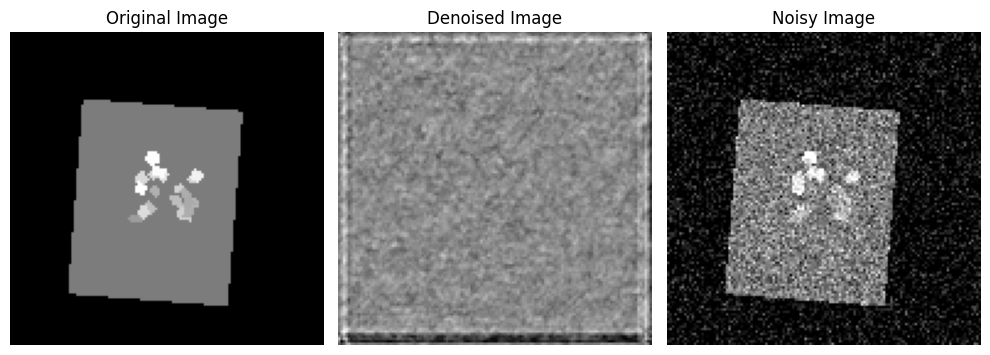

In [236]:

# input image (phantom)
resolution = 7
phantom = generate_phantom(resolution=resolution)

# early stopper
early_stop_callback = _EarlyStopping(
                        monitor="variance", 
                        mode="min", 
                        patience=6, 
                        verbose=True,
                        min_delta=0
                        )

# Create the lightning module
module = LightningEvalSearch(
                phantom=phantom, 
                buffer_size=100,
                num_iter=50,
                lr=0.00005, 
                noise_type='gaussian', 
                noise_factor=0.15, 
                resolution=resolution, 
                )

# Create a PyTorch Lightning trainer
trainer = Trainer(
            callbacks=[early_stop_callback],
            max_epochs=5000, # (max_epochs)*(num_iter) = (Total Iterations) ---> 100 * 50 = 5000 iterations
            fast_dev_run=True,
            gpus=1,
            )
if not hasattr(trainer, 'optimizer_frequencies'):
    trainer.optimizer_frequencies = []


# Create the lighting object for evaluator
train_loader = DataLoader(SingleImageDataset(phantom, num_iter=1), batch_size=1)
val_loader = DataLoader(SingleImageDataset(phantom, num_iter=1), batch_size=1)

lightning = Lightning(lightning_module=module, trainer=trainer, train_dataloaders=train_loader, val_dataloaders=val_loader)


# Create a Search Space
model_space = DARTS_UNet()

# Select the Search Strategy
strategy = DartsStrategy()

fast_dev_run=False

config = RetiariiExeConfig(execution_engine='oneshot')
experiment = RetiariiExperiment(model_space, evaluator=lightning, strategy=strategy)
experiment.run(config)

# attempt 4

In [261]:
class Preprocessor(nn.Module):
    def __init__(self, C_in, C_out):
        super().__init__()

        self.conv1 = nn.Conv2d(C_in, C_out, 1)

    def forward(self, x):
        return [self.conv1(x[0])]

class Postprocessor(nn.Module):
    def __init__(self, C_in, C_out):
        super().__init__()

        self.conv1 = nn.Conv2d(C_in, C_out, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(C_in, C_out, kernel_size=3, padding=1)

    def forward(self, x):
        return [self.conv1(x[0]), self.conv2(x[1])]

@model_wrapper
class DARTS_UNet(nn.Module):
    def __init__(self, C_in=1, C_out=1, depth=4):
        super().__init__()

        # all padding should follow this formula:
        # pd = (ks - 1) * dl // 2
        self.pr = False
        self.depth = depth
        
        self.in_layer = nn.Conv2d(C_in, 64, kernel_size=3, padding=1)

        self.pool1 = Cell(pools(), num_nodes=1, num_ops_per_node=2, num_predecessors=1)
        self.conv1 = Cell(convs(64, 128), num_nodes=1, num_ops_per_node=2, num_predecessors=1)

        self.pool2 = Cell(pools(), num_nodes=1, num_ops_per_node=2, num_predecessors=1)
        self.conv2 = Cell(convs(128, 256), num_nodes=1, num_ops_per_node=2, num_predecessors=1)

        self.pool3 = Cell(pools(), num_nodes=1, num_ops_per_node=2, num_predecessors=1)
        self.conv3 = Cell(convs(256, 512), num_nodes=1, num_ops_per_node=2, num_predecessors=1)

        self.pool4 = Cell(pools(), num_nodes=1, num_ops_per_node=2, num_predecessors=1)
        self.conv4 = Cell(convs(512, 1024), num_nodes=1, num_ops_per_node=2, num_predecessors=1)

        self.encoders = nn.ModuleList([self.pool1, self.conv1, self.pool2, self.conv2, self.pool3, self.conv3, self.pool4, self.conv4])

        self.up1 = Cell(upsamples(), num_nodes=1, num_ops_per_node=2, num_predecessors=1)
        self.conv5 = Cell(convs(512*3, 512), num_nodes=1, num_ops_per_node=2, num_predecessors=1)

        self.up2 = Cell(upsamples(), num_nodes=1, num_ops_per_node=2, num_predecessors=1)
        self.conv6 = Cell(convs(256*3, 256), num_nodes=1, num_ops_per_node=2, num_predecessors=1)

        self.up3 = Cell(upsamples(), num_nodes=1, num_ops_per_node=2, num_predecessors=1)
        self.conv7 = Cell(convs(128*3, 128), num_nodes=1, num_ops_per_node=2, num_predecessors=1)

        self.up4 = Cell(upsamples(), num_nodes=1, num_ops_per_node=2, num_predecessors=1)
        self.conv8 = Cell(convs(64*3, 64), num_nodes=1, num_ops_per_node=2, num_predecessors=1)

        self.decoders = nn.ModuleList([self.up1, self.conv5, self.up2, self.conv6, self.up3, self.conv7, self.up4, self.conv8])

        self.out_layer = nn.Conv2d(64, C_out, kernel_size=3, padding=1)

    def forward(self, x):

        if self.pr:
            print(f'input shape: {x.shape}\n')

        x = self.in_layer(x)  # Apply the initial layer
        skip_connections = [x]
        if self.pr:
            print(f'in_la (x) shape: {x.shape}\n')

        for i in range(self.depth):
            x = self.encoders[2*i]([x])
            x = self.encoders[2*i+1]([x])
            if self.pr:
                print(f'conv {i+1} shape: {x.shape}\n')
            skip_connections.append(x)

        for i in range(self.depth):
            upsampled = self.decoders[2*i]([x])
            cropped = self.crop_tensor(upsampled, skip_connections[-(i+2)])
            x = torch.cat([cropped, upsampled], 1)
            x = self.decoders[2*i+1]([x])
            if self.pr:
                print(f'conv  {i+1} shape: {x.shape}\n')

        x = self.out_layer(x)  # Apply the final layer

        return x

    def crop_tensor(self, target_tensor, tensor):
        target_size = target_tensor.size()[2]  # Assuming height and width are same
        tensor_size = tensor.size()[2]
        delta = tensor_size - target_size
        delta = delta // 2
        return tensor[:, :, delta:tensor_size-delta, delta:tensor_size-delta]
    
    def test(self):
        """
        This will input a random tensor of 1x1x128x128 and test the forward pass.
        """
        self.pr = True
        x = torch.randn(1, 1, 128, 128)
        y = self.forward(x)
        assert y.shape == (1, 1, 128, 128), "Output shape should be (1, 1, 128, 128), got {}".format(y.shape)
        print(f'output shape: {y.shape}\n')
        print("Test passed.\n\n")

model = DARTS_UNet(1, 1)
model.test()


input shape: torch.Size([1, 1, 128, 128])

in_la (x) shape: torch.Size([1, 64, 128, 128])

conv 1 shape: torch.Size([1, 128, 64, 64])

conv 2 shape: torch.Size([1, 256, 32, 32])

conv 3 shape: torch.Size([1, 512, 16, 16])

conv 4 shape: torch.Size([1, 1024, 8, 8])

conv  1 shape: torch.Size([1, 512, 16, 16])

conv  2 shape: torch.Size([1, 256, 32, 32])

conv  3 shape: torch.Size([1, 128, 64, 64])

conv  4 shape: torch.Size([1, 64, 128, 128])

output shape: torch.Size([1, 1, 128, 128])

Test passed.




/home/joe/.cache/pypoetry/virtualenvs/nas-test-OHy8kATa-py3.8/lib/python3.8/site-packages/nni/nas/nn/pytorch/choice.py:274: UserWarning: You should not run forward of this module directly.
  warnings.warn('You should not run forward of this module directly.')
/home/joe/.cache/pypoetry/virtualenvs/nas-test-OHy8kATa-py3.8/lib/python3.8/site-packages/nni/nas/nn/pytorch/choice.py:186: UserWarning: You should not run forward of this module directly.
  warnings.warn('You should not run forward of this module directly.')


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).
`Trainer(limit_train_batches=1)` was configured so 1 batch per epoch will be used.
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_test_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_predict_batches=1)` was configured so 1 batch will be used.
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                | Params
----------------------------------------------
0 | model | LightningEvalSearch | 38.4 M
----------------------------------------------
38.4 M    Trainable params
0         Non-trainable params
38.4 M    Total params
153.795   Total estimated model params size (

Training: 0it [00:00, ?it/s]

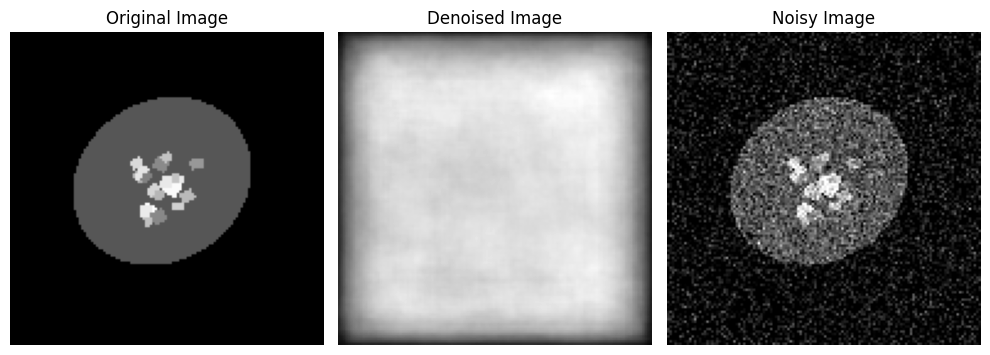

In [270]:

# input image (phantom)
resolution = 7
phantom = generate_phantom(resolution=resolution)

# early stopper
early_stop_callback = _EarlyStopping(
                        monitor="variance", 
                        mode="min", 
                        patience=6, 
                        verbose=True,
                        min_delta=0
                        )

# Create the lightning module
module = LightningEvalSearch(
                phantom=phantom, 
                buffer_size=100,
                num_iter=50,
                lr=0.00005, 
                noise_type='gaussian', 
                noise_factor=0.15, 
                resolution=resolution, 
                )

# Create a PyTorch Lightning trainer
trainer = Trainer(
            callbacks=[early_stop_callback],
            max_epochs=3000, # (max_epochs)*(num_iter) = (Total Iterations) ---> 100 * 50 = 5000 iterations
            fast_dev_run=True,
            gpus=1,
            )
if not hasattr(trainer, 'optimizer_frequencies'):
    trainer.optimizer_frequencies = []


# Create the lighting object for evaluator
train_loader = DataLoader(SingleImageDataset(phantom, num_iter=1), batch_size=1)
val_loader = DataLoader(SingleImageDataset(phantom, num_iter=1), batch_size=1)

lightning = Lightning(lightning_module=module, trainer=trainer, train_dataloaders=train_loader, val_dataloaders=val_loader)


# Create a Search Space
model_space = DARTS_UNet()

# Select the Search Strategy
strategy = DartsStrategy()

fast_dev_run=False

config = RetiariiExeConfig(execution_engine='oneshot')
experiment = RetiariiExperiment(model_space, evaluator=lightning, strategy=strategy)
experiment.run(config)

# attempt 5

In [13]:
def conv_2d(C_in, C_out, kernel_size=3, dilation=1, padding=1, activation=None):
    return nn.Sequential(
        nn.Conv2d(C_in, C_out, kernel_size=kernel_size, dilation=dilation, padding=padding, bias=False),
        nn.BatchNorm2d(C_out),
        nn.ReLU() if activation is None else activation,
        nn.Conv2d(C_out, C_out, kernel_size=kernel_size, dilation=dilation, padding=padding, bias=False),
        nn.BatchNorm2d(C_out),
        nn.ReLU() if activation is None else activation
    )

def depthwise_separable_conv(C_in, C_out, kernel_size=3, dilation=1, padding=1):
    return nn.Sequential(
        nn.Conv2d(C_in, C_in, kernel_size=kernel_size, dilation=dilation, padding=padding, groups=C_in, bias=False),
        nn.Conv2d(C_in, C_out, 1, bias=False),
        nn.BatchNorm2d(C_out),
        nn.ReLU(),
        nn.Conv2d(C_out, C_out, kernel_size=kernel_size, dilation=dilation, padding=padding, groups=C_out, bias=False),
        nn.Conv2d(C_out, C_out, 1, bias=False),
        nn.BatchNorm2d(C_out),
        nn.ReLU()
    )

def maxpool_2d_conv2d(C_in, C_out):
    return nn.Sequential(
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        conv_2d(C_in, C_out)
        )

def maxpool_2d_depthwise_separable_conv(C_in, C_out):
    return nn.Sequential(
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        depthwise_separable_conv(C_in, C_out)
        )

def avgpool_2d_conv2d(C_in, C_out):
    return nn.Sequential(
        nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
        conv_2d(C_in, C_out)
        )

def avgpool_2d_depthwise_separable_conv(C_in, C_out):
    return nn.Sequential(
        nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
        depthwise_separable_conv(C_in, C_out)
        )

def nearest_upsample_conv2d(C_in, C_out, scale_factor=2):
    return nn.Sequential(
        nn.Upsample(scale_factor=scale_factor, mode='nearest'),
        conv_2d(C_in, C_out)
        )

def nearest_upsample_depthwise_separable_conv(C_in, C_out, scale_factor=2):
    return nn.Sequential(
        nn.Upsample(scale_factor=scale_factor, mode='nearest'),
        depthwise_separable_conv(C_in, C_out)
        )

def bilinear_upsample_conv2d(C_in, C_out, scale_factor=2):
    return nn.Sequential(
        nn.Upsample(scale_factor=scale_factor, mode='bilinear'),
        conv_2d(C_in, C_out)
        )

def bilinear_upsample_depthwise_separable_conv(C_in, C_out, scale_factor=2):
    return nn.Sequential(
        nn.Upsample(scale_factor=scale_factor, mode='bilinear'),
        depthwise_separable_conv(C_in, C_out)
        )

def encoder_ops(C_in,C_out):
    return [
    maxpool_2d_conv2d(C_in, C_out),
    maxpool_2d_depthwise_separable_conv(C_in, C_out),
    avgpool_2d_conv2d(C_in, C_out),
    avgpool_2d_depthwise_separable_conv(C_in, C_out)
]

def decoder_ops(C_in,C_out):
    return [
    nearest_upsample_conv2d(C_in, C_out),
    nearest_upsample_depthwise_separable_conv(C_in, C_out),
    bilinear_upsample_conv2d(C_in, C_out),
    bilinear_upsample_depthwise_separable_conv(C_in, C_out)
]

def pools():
    return [
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
    ]

def upsamples():
    return [
        nn.Upsample(scale_factor=2, mode='nearest'),
        nn.Upsample(scale_factor=2, mode='bilinear'),
    ]

def convs(C_in, C_out):
    return [
        nn.Conv2d(C_in, C_out, kernel_size=3, padding=1),
        nn.Conv2d(C_in, C_out, kernel_size=3, padding=1, activation=nn.Sigmoid()),
        nn.Conv2d(C_in, C_out, kernel_size=3, padding=1, activation=nn.SiLU()),
        depthwise_separable_conv(C_in, C_out)
    ]

class Preprocessor(nn.Module):
    def __init__(self, C_in, C_out):
        super().__init__()

        self.conv1 = nn.Conv2d(C_in, C_out, 1)

    def forward(self, x):
        return [self.conv1(x[0])]

class Postprocessor(nn.Module):
    def __init__(self, C_in, C_out):
        super().__init__()

        self.conv1 = nn.Conv2d(C_in, C_out, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(C_in, C_out, kernel_size=3, padding=1)

    def forward(self, x):
        return [self.conv1(x[0]), self.conv2(x[1])]

@model_wrapper
class DARTS_UNet(nn.Module):
    def __init__(self, C_in=1, C_out=1, depth=4):
        super().__init__()

        # all padding should follow this formula:
        # pd = (ks - 1) * dl // 2
        self.pr = False
        self.depth = depth
        
        self.in_layer = nn.Conv2d(C_in, 64, kernel_size=3, padding=1)

        # Encoders
        filters = 64
        self.encoders = nn.ModuleList()
        for i in range(depth):
            self.encoders.append(Cell(pools(), num_nodes=1, num_ops_per_node=2, num_predecessors=1))
            self.encoders.append(Cell(convs(filters, filters*2), num_nodes=1, num_ops_per_node=2, num_predecessors=1))
            filters *= 2

        # Decoders
        self.decoders = nn.ModuleList()
        for i in range(depth):
            self.decoders.append(Cell(upsamples(), num_nodes=1, num_ops_per_node=2, num_predecessors=1))
            filters //= 2
            self.decoders.append(Cell(convs(filters*3, filters), num_nodes=1, num_ops_per_node=2, num_predecessors=1))

        self.out_layer = nn.Conv2d(64, C_out, kernel_size=3, padding=1)

    def forward(self, x):

        if self.pr:
            print(f'input shape: {x.shape}\n')

        x = self.in_layer(x)  # Apply the initial layer
        skip_connections = [x]

        for i in range(self.depth):
            x = self.encoders[2*i]([x])
            x = self.encoders[2*i+1]([x])
            skip_connections.append(x)

        for i in range(self.depth):
            upsampled = self.decoders[2*i]([x])
            cropped = self.crop_tensor(upsampled, skip_connections[-(i+2)])
            x = torch.cat([cropped, upsampled], 1)
            x = self.decoders[2*i+1]([x])

        x = self.out_layer(x)  # Apply the final layer

        return x

    def crop_tensor(self, target_tensor, tensor):
        target_size = target_tensor.size()[2]  # Assuming height and width are same
        tensor_size = tensor.size()[2]
        delta = tensor_size - target_size
        delta = delta // 2
        return tensor[:, :, delta:tensor_size-delta, delta:tensor_size-delta]
    
    def test(self):
        """
        This will input a random tensor of 1x1x128x128 and test the forward pass.
        """
        self.pr = True
        x = torch.randn(1, 1, 128, 128)
        y = self.forward(x)
        assert y.shape == (1, 1, 128, 128), "Output shape should be (1, 1, 128, 128), got {}".format(y.shape)
        print(f'output shape: {y.shape}\n')
        print("Test passed.\n\n")

model = DARTS_UNet(1, 1)
model.test()


TypeError: __init__() got an unexpected keyword argument 'activation'

In [10]:
class SingleImageDataset(Dataset):
    def __init__(self, image, num_iter):
        self.image = image
        self.num_iter = num_iter

    def __len__(self):
        return self.num_iter

    def __getitem__(self, index):
        # Always return the same image (and maybe a noise tensor or other information if necessary??)
        return self.image

@trace
class LightningEvalSearch(LightningModule):
    def __init__(self, phantom=None, buffer_size=100, num_iter=50,
                lr=0.00005, noise_type='gaussian', noise_factor=0.15, resolution=6, 
                n_channels=1, reg_noise_std_val=1./30.):
        super().__init__()

        # input
        self.phantom = phantom

        # Loss
        self.criterion = nn.MSELoss().to(self.device)
        
        # Hyperparameters / Inputs
        self.buffer_size = buffer_size
        self.num_iter = num_iter
        self.lr = lr
        self.noise_type = noise_type
        self.noise_factor = noise_factor
        self.resolution = resolution
        self.n_channels = n_channels
        self.reg_noise_std = tensor(reg_noise_std_val)

        # adjusting input
        if self.phantom is None:
            self.img_np, _, _, self.img_noisy_torch = self.preprocess_image(self.resolution, self.noise_type, self.noise_factor)
        else:
            self.img_np, _, _, self.img_noisy_torch = self.preprocess_image(self.resolution, self.noise_type, self.noise_factor, input_img_np=self.phantom)
        self.net_input = get_noise(input_depth=1, spatial_size=self.img_np.shape[1], noise_type=self.noise_type)
        
        # History and early stopper
        self.loss_history = []
        self.variance_history = []
        self.img_collection = []
        
    def forward(self, net_input):
        net_input_perturbed = net_input + zeros_like(net_input).normal_(std=self.reg_noise_std)
        return self.model(net_input_perturbed)
    
    def training_step(self, batch, batch_idx):
        """
        Deep Image Prior

        training here follows closely from the following two repos: 
            - the deep image prior repo
            - a DIP early stopping repo (Lighting has early stopping functionality so this blends the two)
        """        

        r_img_torch = self.forward(self.net_input)
        r_img_np = torch_to_np(r_img_torch)

        # update loss and loss history
        total_loss = self.criterion(r_img_torch, self.img_noisy_torch)
        self.loss_history.append(total_loss.item())
        self.logger.log_metrics({'loss': total_loss.item()})

        # Using global_step to count iterations
        iterator = self.global_step

        # update img collection
        r_img_np = r_img_np.reshape(-1)
        self.update_img_collection(r_img_np)
        img_collection = self.get_img_collection()

        # if len(img_collection) == self.buffer_size:
        if len(img_collection) >= self.buffer_size // 2:

            # update variance and var history
            ave_img = np.mean(img_collection, axis=0)
            variance = [MSE(ave_img, tmp) for tmp in img_collection]
            self.cur_var = np.mean(variance)
            self.variance_history.append(self.cur_var)

            # update log
            self.latest_loss = total_loss.item()
            self.log('variance', self.cur_var)
            self.log('loss', self.latest_loss)
            nni.report_intermediate_result({'Iteration':iterator,'variance':self.cur_var, 'loss': self.latest_loss})

        return {"loss": total_loss}

    def configure_optimizers(self):
        """
        Basic Adam Optimizer
        """
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        return optimizer
    
    def optimizer_zero_grad(self, epoch, batch_idx, optimizer, opt_idx):
        # Not sure if this is the default logic in the nni.retiarii.evaluator.pytorch.LightningModule
        # needed to modify so it can accept the opt_idx argument
        optimizer.zero_grad()
    
    def configure_gradient_clipping(self, optimizer, opt_idx, gradient_clip_val, gradient_clip_algorithm):
        # Not sure if this is the default logic in the nni.retiarii.evaluator.pytorch.LightningModule
        # needed to modify so it can accept the opt_idx argument
        # now need to define the clipping logic
        self.clip_gradients(
            optimizer,
            gradient_clip_val=gradient_clip_val,
            gradient_clip_algorithm=gradient_clip_algorithm
        )


    def set_model(self, model):
        # This will be called after __init__ and will set the candidate model
        self.model = model
    
    def train_dataloader(self):
        """
        Dummy DataLoader that returns nothing but makes PyTorch Lightning's training loop work
        """
        dataset = SingleImageDataset(self.phantom, self.num_iter)
        return DataLoader(dataset, batch_size=1)
    
    def on_train_start(self):
        """
        Move all tensors to the GPU to begin training
        """
        self.model.to(self.device)
        self.net_input = self.net_input.to(self.device)
        self.img_noisy_torch = self.img_noisy_torch.to(self.device)
        self.reg_noise_std = self.reg_noise_std.to(self.device)

    def on_train_end(self, **kwargs: Any):
        """
        Report final PSNR to NNI and display the results
        """

        # final log
        # self.logger.log_metrics({'variance':self.cur_var, 'loss': self.latest_loss})
        # nni.report_final_result({'variance':self.cur_var, 'loss': self.latest_loss})

        # plot images to see results
        denoised_img = self.forward(self.net_input).detach().cpu().squeeze().numpy()
        
        fig, ax = plt.subplots(1, 3, figsize=(10, 5))

        ax[0].imshow(self.img_np.squeeze(), cmap='gray')
        ax[0].set_title("Original Image")
        ax[0].axis('off')

        ax[1].imshow(denoised_img, cmap='gray')
        ax[1].set_title("Denoised Image")
        ax[1].axis('off')

        ax[2].imshow(self.img_noisy_torch.detach().cpu().squeeze().numpy(), cmap='gray')
        ax[2].set_title("Noisy Image")
        ax[2].axis('off')

        plt.tight_layout()
        plt.show()

    # def test_step(self, *args: Any, **kwargs: Any) -> STEP_OUTPUT | None:
    #     pass

    def val_dataloader(self):
        """
        Dummy DataLoader for validation.
        """
        dataset = SingleImageDataset(self.phantom, self.num_iter)
        return DataLoader(dataset, batch_size=1)
    
    # def validation_step(self, trainer, *args: Any, **kwargs: Any) -> STEP_OUTPUT | None:
    #     # if self.buffer_size == len(self.img_collection):
    #     #     self._run_early_stopping_check(trainer)
    #     pass

    def update_img_collection(self, cur_img):
        self.img_collection.append(cur_img)
        if len(self.img_collection) > self.buffer_size:
            self.img_collection.pop(0)

    def get_img_collection(self):
        return self.img_collection

    def preprocess_image(self, resolution, noise_type, noise_factor, input_img_np=None):
        """
        Generates an image (or takes an input phantom), adds noise, and converts it to both numpy and torch tensors.

        Args:
        - resolution (int): Resolution for the phantom image.
        - noise_type (str): Type of noise to add.
        - noise_factor (float): Noise factor.
        - input_img_np (numpy.ndarray, optional): Input raw image in numpy format. If not provided, a new image will be generated.

        Returns:
        - img_np (numpy.ndarray): Original image in numpy format.
        - img_noisy_np (numpy.ndarray): Noisy image in numpy format.
        - img_torch (torch.Tensor): Original image in torch tensor format.
        - img_noisy_torch (torch.Tensor): Noisy image in torch tensor format.
        """
        if input_img_np is None:
            raw_img_np = generate_phantom(resolution=resolution) # 1x64x64 np array
        else:
            raw_img_np = input_img_np.copy() # 1x64x64 np array
            
        img_np = raw_img_np.copy() # 1x64x64 np array
        img_torch = torch.tensor(raw_img_np, dtype=torch.float32).unsqueeze(0) # 1x1x64x64 torch tensor
        img_noisy_torch = add_selected_noise(img_torch, noise_type=noise_type, noise_factor=noise_factor) # 1x1x64x64 torch tensor
        img_noisy_np = img_noisy_torch.squeeze(0).numpy() # 1x64x64 np array
        
        return img_np, img_noisy_np, img_torch, img_noisy_torch

class _EarlyStopping(EarlyStopping, pl.Callback):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

In [11]:

# input image (phantom)
resolution = 7
phantom = generate_phantom(resolution=resolution)

# early stopper
early_stop_callback = _EarlyStopping(
                        monitor="variance", 
                        mode="min", 
                        patience=6, 
                        verbose=True,
                        min_delta=0
                        )

# Create the lightning module
module = LightningEvalSearch(
                phantom=phantom, 
                buffer_size=100,
                num_iter=50,
                lr=0.00005, 
                noise_type='gaussian', 
                noise_factor=0.15, 
                resolution=resolution, 
                )

# Create a PyTorch Lightning trainer
trainer = Trainer(
            # callbacks=[early_stop_callback],
            max_epochs=3000, # (max_epochs)*(num_iter) = (Total Iterations) ---> 100 * 50 = 5000 iterations
            fast_dev_run=False,
            gpus=1,
            )
if not hasattr(trainer, 'optimizer_frequencies'):
    trainer.optimizer_frequencies = []


# Create the lighting object for evaluator
train_loader = DataLoader(SingleImageDataset(phantom, num_iter=1), batch_size=1)
val_loader = DataLoader(SingleImageDataset(phantom, num_iter=1), batch_size=1)

lightning = Lightning(lightning_module=module, trainer=trainer, train_dataloaders=train_loader, val_dataloaders=val_loader)


# Create a Search Space
model_space = DARTS_UNet()

# Select the Search Strategy
strategy = DartsStrategy()

fast_dev_run=False

config = RetiariiExeConfig(execution_engine='oneshot')
experiment = RetiariiExperiment(model_space, evaluator=lightning, strategy=strategy)
experiment.run(config)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


TypeError: __init__() got an unexpected keyword argument 'activation'

In [15]:

from nni.experiment import Experiment
experiment = Experiment.connect(8081)
experiment.stop()

ConnectionError: HTTPConnectionPool(host='localhost', port=8081): Max retries exceeded with url: /api/v1/nni/experiment (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fe482e29a90>: Failed to establish a new connection: [Errno 111] Connection refused'))